In [84]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import json

In [83]:
f = open('data.json')
 
# returns JSON object as 
# a dictionary
data = json.load(f)

f.close()

In [82]:
Data = data[0];
P_b = Data["P_b"]

params_means = [10.45, 0.33, 7.5]
params_stddevs = [2.03, 0.08, 1.5]
lower_bounds = [0.01, 0.01, -10.0]
upper_bounds = [50.0, 1.0, P_b]
Ib_max = 1.00
Ib_min = 0.01



In [85]:
# CSF dynamics model
def dyn_model(Rcsf, E, P_0):
    I_b = (Data["P_b"] - P_0) / Rcsf # CSF formation rate

    infstart = Data['infusion_start']
    infend = Data["infusion_end"]
    I_inf = Data["I_inf"]

    Rn = Data["Rn"] # Needle resistance (one-needle)
    dP = Data["P_b"] - P_0
    It = I_b + I_inf

    t = (np.arange(infstart, infend + 1) - infstart) / 6.0
    Pm = It * dP / (I_b + (I_inf * np.exp(-E * It * t))) + P_0 + (I_inf * Rn)

    return Pm

In [131]:
with pm.Model() as model:

    # Priors
    E = pm.TruncatedNormal('E', mu=params_means[1], sigma=params_stddevs[1], lower=lower_bounds[1], upper=upper_bounds[1])
    P0 = pm.TruncatedNormal('P0', mu=params_means[2], sigma=params_stddevs[2], lower=lower_bounds[2], upper=upper_bounds[2])
    Rout = pm.TruncatedNormal('Rout', mu=params_means[0], sigma=params_stddevs[0], lower=lower_bounds[0], upper=upper_bounds[0])
    
    # # Soft Constraint (Potential)
    Ib = (Data["P_b"] - P0) / Rout
    min_value = 0.01
    max_value = 1.00
    is_acceptable = ((min_value <= Ib) & (Ib <= max_value))
    constraint_penalty = pm.math.switch(is_acceptable, 0.0, np.inf)
    pm.Potential('constraint_penalty', -constraint_penalty)
    
    # Standard deviation for the likelihood
    sigma = pm.TruncatedNormal('sigma', mu=0, sigma=1, lower=0, upper=np.inf)
    
    # Compute model predictions
    predicted = dyn_model(Rout, E, P0)
    
    # Likelihood (Gaussian)
    likelihood = pm.Normal('likelihood', mu=predicted, sigma=sigma, observed=Data["pressure"][Data['infusion_start']-1:Data['infusion_end']])


In [132]:
with model:
    # draw 1000 posterior samples
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [E, P0, Rout, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
There were 2618 divergences after tuning. Increase `target_accept` or reparameterize.


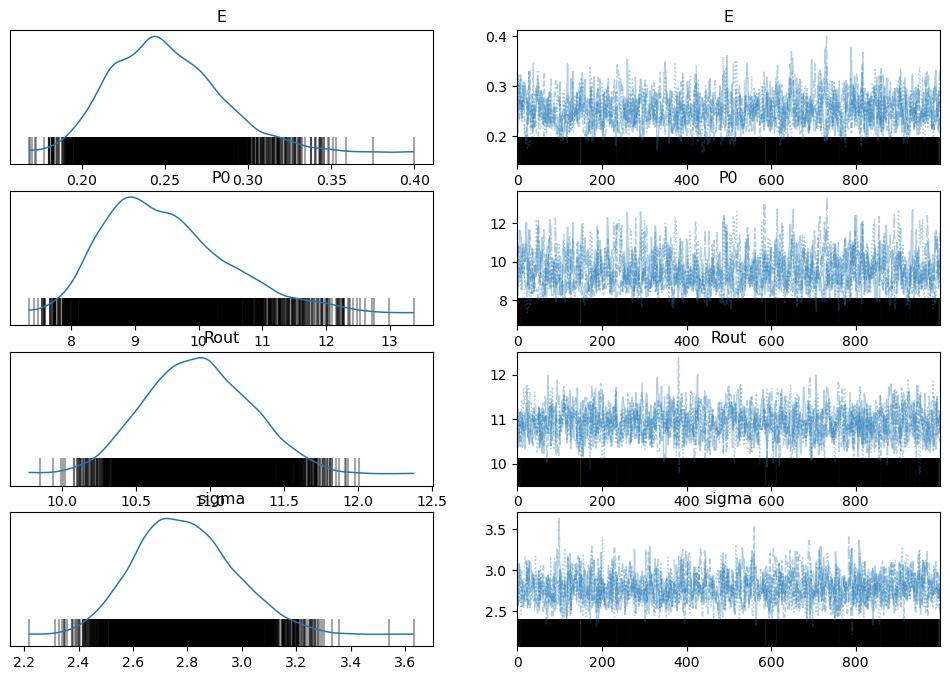

In [133]:
az.plot_trace(idata, combined=True);

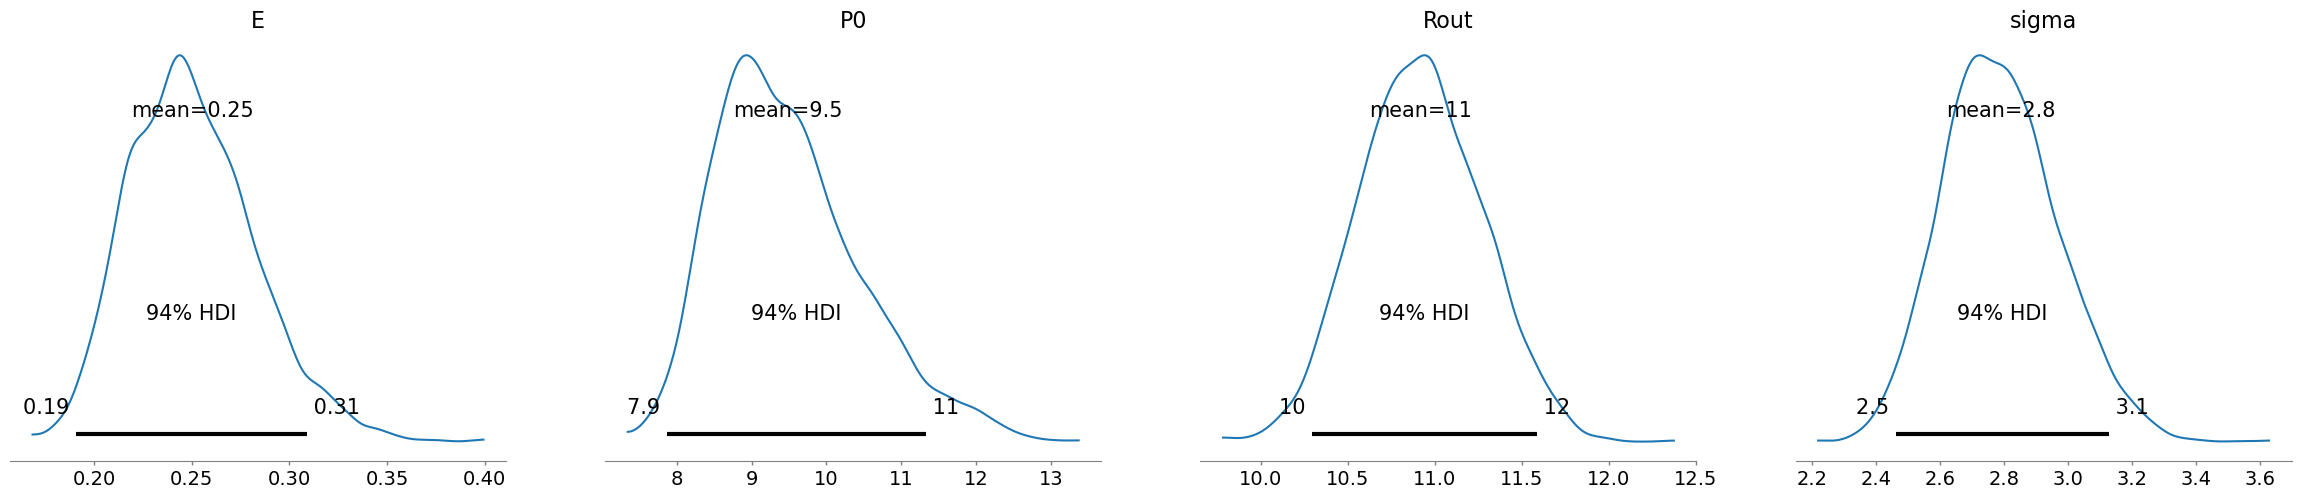

In [134]:
az.plot_posterior(idata, show=True);

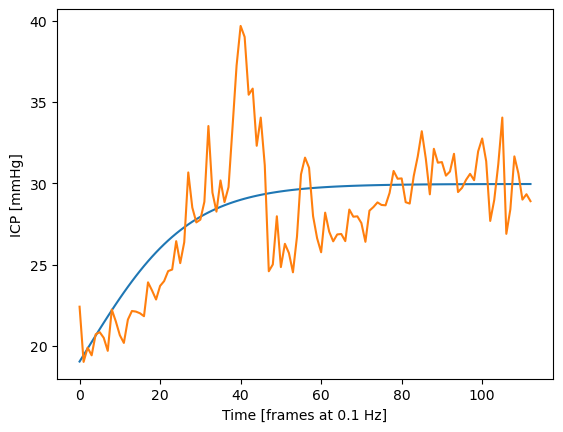

In [139]:
Rout = float(np.mean(idata.posterior.Rout))
P0 = float(np.mean(idata.posterior.P0))
E = float(np.mean(idata.posterior.E))

icp_trace = Data["pressure"][Data['infusion_start']-1:Data['infusion_end']]

plt.plot(dyn_model(Rout, E, P0))
plt.plot(icp_trace)
plt.xlabel('Time [frames at 0.1 Hz]')
plt.ylabel('ICP [mmHg]')
plt.savefig('fit.png')

